# WARP Tutorial

This notebook takes the pedagogy of learn by example, showing how to use WARP to organize your project's pipeline and keep track of hyperparameters therein.

In [1]:
%load_ext autoreload
%autoreload 2

# Declaring pipes

The following cell(s) will show how to define a pipe that can be recognized by WARP.
Pipes currently must be declared in external files (i.e. not within a notebook) with a strict one-pipe-per-file rule.

This next cell shows the contents of the file `./example/A.py`, which defines an initial pipe for this pipeline.
The following features of WARP are showcased:
- **Parameters:** Parameters are intended to be tunable values necessary to reproduce a pipe's output (e.g. learning rate of a neural network). 
Parameters are limited to simple types (string, numeric types) as well as basic iterables (list, dict) containing simple types.
The first argument of the `Parameter` constructor is always the parameter name and the keyword argument `default` can be passed to specify a default value.
If no `default` argument is passed (e.g. `Parameter('text')`), then the parameter assumes the default value of the string equal to its name (concretely, the value contained in `Parameter('text')` is `'text'`).
A parameter can be treated within `Main` like a variable containing the value that `Parameter` wraps.

- **Parameter config files:** A config file for the pipe parameters can be specified using the `ParameterFile` class, which takes one string argument corresponding to the file path of the config file (relative to the working directory).
This config file can be in yaml or json format -- the codeblock below shows a yaml example:
```
# contents of the file `config/A.yml`
message: text_yaml
```
Parameters in the config file must have names that match their variable names (e.g. `message: text_yaml` will be matched to an attribute `message = Parameter(...)`).
Config files can be used to override the default values for a parameter (in this case, we override the `message` string value `'text'` with `'text_yaml'`), thus you don't need to specify every parameter of the pipe if the default values suffice. 
All parameter values used at runtime are logged by WARP automatically.

- **Product specification:** you must specify a pipe's products using the `Product` class, which takes one string argument corresponding to the file path for the product to be generated.
You can treat instances of this object as the string it contains.
The `Product` class accepts strings, lists, and dicts.

- **Lazy imports:** the preference when declaring WARP pipes is to lazily import modules that are used within the pipe. You don't have to adhere to this rule of thumb, but doing so will significantly speedup the launching of sessions.
`warp.utils.GlobalImport` provides a convenient way of doing lazy imports for your pipe, as shown in the next cell.
Using `GlobalImport` will allow you to import any number of modules which will be available to any object within scope.

In [2]:
"""example/A.py

Creates two output files `A1.txt` and `A2.txt` that both contain the value of the `message` parameter.
The `message` parameter value is stored in the `config/A.yml` file.
"""
from warp import Pipe, Product, Parameter, ParameterFile
from warp.utils import GlobalImport

class Main(Pipe):
    ### parameters
    config_file = ParameterFile('config/A.yml')
    message = Parameter('text')

    ### products
    products = Product([
        'data/A1.txt', 
        'data/A2.txt'])

    @staticmethod
    def makedirs(path :str) -> None:
        # `os` module is available due to GlobalImport
        os.makedirs(path, exist_ok=True)

    def run(self) -> None:
        # lazy imports
        with GlobalImport(globals()):
            import os

        self.makedirs('data')
        for p in self.products:
            with open(p, 'w') as f:
                f.write(self.message)

# Instantiating the graph

In [3]:
from warp import PipeGraph, WorkSpace
from example import A, B, C, D

In [4]:
pg = PipeGraph()

The next cell shows how external files can be included in a WARP pipeline.
These kinds of nodes in the graph are considered source nodes from a flow perspective -- nodes with no parents.
Note that source nodes are not a required component of a WARP pipeline, they are only a convenience for tracking externally generated data in your workflow.

Intuitively, one only needs to specify a product with no pipe file and no parent_products.
Here, we add a config file for a downstream pipe -- this is not necessary in practice since WARP will log parameter values later anyways.

In [5]:
pg.add(products='config/A.yml')

Next, we can add a pipe to the graph that depends on the product of previous pipe (in this case, the source pipe).
We only need to name a product in the `parent_products` argument that was generated by pipe already attached to the graph.
Specifying a config file as a product 

Since a pipe's products are always specified locally using the `Product` class (as seen above), specifying them via the `products` argument to `pg.add` is unnecessary. 
The only reason to specify products redundantly is for verbosity purposes, which can be handy when developing a pipeline.

- **Note:** specifying products at `PipeGraph` creation time can lead to excessive verbosity -- prefer implicit product specifications, similar to parameters.

In [6]:
pg.add(
    parent_products='config/A.yml',
    pipe=A)

You can pass a module to the `parents` argument to automatically add all products of the pipe as dependencies.
In this case, by passing `parents=A`, WARP adds `'data/A1.txt'` and `'data/A2.txt'` as dependencies of `B`.

In [7]:
pg.add(
    parents=A,
    pipe=B)

Since all of a pipe's products are specified as attributes, we can directly pass them in to the `parent_products` argument.
This allows us to exclude certain products of an upstream pipe that we don't need.

In [8]:
pg.add(
    parent_products=A.Main.products[1],  # data/A2.txt
    pipe=C)

**Note:** terminal pipes in the pipeline don't have to have products -- this is a choice left to the user.
Here, we indicate optionality using the commented line.

In [9]:
pg.add(
    parents=[A, C],
    pipe=D)

In [10]:
ws = WorkSpace(
    pathgraph=pg,
    config_dir='./config')

To make sure that we're working in a fresh environment, we can clear the cache.
You can clear all workspace sessions by passing the `clear_all=True` flag.
You can clear the cache for a particular session by passing its id number (e.g. `ws.clear_cache(0)`).

In [11]:
ws.clear_cache(clear_all=True)

/Users/jwhelland/Documents/work/repos/warp/warp/home.py:15: UserWarning: home /Users/jwhelland/Documents/work/repos/warp/example/.warp not found, creating...
  warnings.warn('home {:s} not found, creating...'.format(os.path.abspath(self.path)))
/Users/jwhelland/Documents/work/repos/warp/warp/home.py:28: UserWarning: no session with id 0 found, creating...
  warnings.warn('no session with id {} found, creating...'.format(self.session_id))


# Visualizing the graph

We can visually inspect the graph we built using `view`. This can let us check for discrepencies in the graph at a glance.

The `__source__` pipe corresponds to the external artifact that we attached using `pg.add(products='config/A.yml')`.

Notice that `B` is a terminal node -- pipes `C` and `D` do not depend on this pipe in any way.

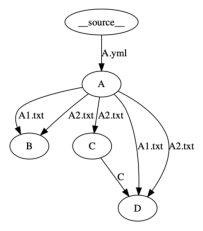

In [12]:
ws.show()

You can get a view that is more verbose (i.e. provides relative paths for everything):

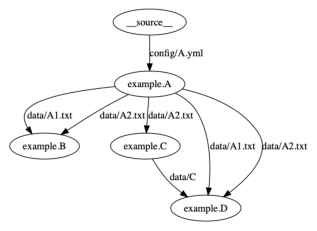

In [13]:
ws.show(verbose=True)

# Running pipes in the graph

Now that we've defined our graph and instantiated our workspace, we're ready to start running pipes.

In [14]:
ws.methods

['PG',
 'accepted_config_ext',
 'backfill',
 'build',
 'clear_cache',
 'config_dir',
 'configs',
 'create_session',
 'home',
 'list_parameters',
 'load_external_parameters',
 'load_session',
 'methods',
 'pipes',
 'sessions',
 'show',
 'status',
 'view',
 'view_pipe']

In [15]:
ws.pipes

NodeView(('__source__', 'example.A', 'example.B', 'example.C', 'example.D'))

We can view the source code of a pipe using `ws.view_pipe(...)`.
Notice that this matches the example pipe declaration code written in the cell above. 

In [16]:
ws.view_pipe('A')

We want to get the products of the `example.D` pipe but we don't want to think about which pipes we need to run in which order to get there (e.g. `example.B` is not necessary for `example.D`).
We also don't want to remember which of the intermediate pipes we might need to rerun to preserve data provenance.
This is the core functionality of WARP; we can use the `backfill` operation to find the ordered sequence of pipes that need to be rerun.
Critically, WARP will only include a pipe in this sequence if an upstream pipe has been run more recently.

When we run `ws.backfill('D')` in the following cell, we haven't actually run any of the pipes before, so WARP will choose the build sequence `A -> B -> C -> D`.

In [17]:
%%time
ws.backfill('D')

main() in /Users/jwhelland/Documents/work/repos/warp/example/example/C.py


CPU times: user 464 ms, sys: 80.8 ms, total: 545 ms
Wall time: 608 ms


When we ran `backfill` on the pipe `D`, WARP automatically detected that the ancestral pipes of `D` were out of sync (in this case, they had never been built).
In this case, WARP noticed that `D` has no dependency on `B`, so `B` was left unbuilt.
We can confirm this by checking the `status` of `B`.

In [18]:
ws.status('B')

The `backfill` function is idempotent -- running backfill again does nothing.

In [19]:
ws.backfill('D')

---
Suppose we want to regenerate the products of `C` with different parameter values.
We can do this using `build` and passing in keyword arguments that correspond to parameter names.
In this case, `C` has a parameter called `message`.

In [20]:
ws.build('A', message='new message')

/Users/jwhelland/Documents/work/repos/warp/warp/workspace.py:436: UserWarning: overriding parameter `message` config value `text_yaml` with user-specified value `new message`
  p, self.configs[pipe_name][p], parameters[p]))


If we try to build `D`, WARP will detect that the graph is now out-of-sync and will throw an error.
The methodology of WARP is to put hard stops in place to prevent bugs that arise from using out-of-sync data.

For dev purposes, you can force a pipe to run by passing the flag `force_build=True`.
You probably shouldn't do this.

In [21]:
ws.build('D')

Per the hint, we can resync the graph via `backfill`.

In [22]:
ws.backfill('D')

main() in /Users/jwhelland/Documents/work/repos/warp/example/example/C.py


# Loading a session

You can inspect sessions

In [23]:
ws.load_session(0)

You can inspect metadata associated with a pipe in the session using `view`
- **pipe cache directory** is the relative path to where the specified pipe's metadata and logs are cached
- **Commit hash** is the hash of the git commit of the code that was used to run the pipe
- **Last build** is a timestamp of when a pipe build was last initiated
- **Elapsed time** is the number of seconds the last pipe build took to complete
- **Parameters** shows the parameter values that were used in the last pipe build

In [24]:
ws.status('A')